# Update basal melt database and example plots

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/basal_melt_param/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41829,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:38097,Total threads: 4
Dashboard: /proxy/39927/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:36049,


In [3]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# temperature of meltwater at the freezing point calculated with the in situ salinity:
Tfreezing_insituS = 'accessom2-GPC001'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tfreezing_zeroS = 'accessom2-GPC002'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tfreezing_min = 'accessom2-GPC003'

start_time='2150-01-01'
end_time='2154-12-31'

lat_slice  = slice(-80,-59)

In [4]:
# build database for these experiments:
session_name = '/g/data/v45/akm157/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC001/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC002/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC003/',]
cc.database.build_index(dir_list,basal_melt_session)


Indexing experiment: accessom2-GPC001


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC002


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC003


0it [00:00, ?it/s]


0

In [19]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

## Check runoff flux:
Looks like this diagnostic doesn't work for the new meltwater simulations...

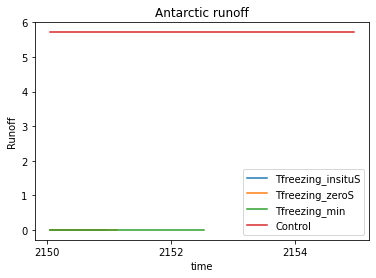

In [13]:
# whole Antarctica:

runoff_con = cc.querying.getvar(control, 'runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_con = runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_con = runoff_con.sum('yt_ocean').sum('xt_ocean').load()

runoff_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_insituS = runoff_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_insituS = runoff_Tfreezing_insituS.sum('yt_ocean').sum('xt_ocean').load()

runoff_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_zeroS = runoff_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_zeroS = runoff_Tfreezing_zeroS.sum('yt_ocean').sum('xt_ocean').load()

runoff_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_min = runoff_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_min = runoff_Tfreezing_min.sum('yt_ocean').sum('xt_ocean').load()

runoff_Tfreezing_insituS.plot(label='Tfreezing_insituS')
runoff_Tfreezing_zeroS.plot(label='Tfreezing_zeroS')
runoff_Tfreezing_min.plot(label='Tfreezing_min')
runoff_con.plot(label='Control')
plt.title('Antarctic runoff')
plt.ylabel('Runoff')
plt.legend();

## Maps of bottom temperature anomaly:

In [7]:

start_time='2151-01-01'
end_time='2151-12-31'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time')

temp_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_insituS = temp_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_Tfreezing_insituS = temp_Tfreezing_insituS.mean('time')

temp_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_zeroS = temp_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_Tfreezing_zeroS = temp_Tfreezing_zeroS.mean('time')

temp_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min = temp_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_Tfreezing_min = temp_Tfreezing_min.mean('time')


2022-07-21 14:02:27,010 - distributed.nanny - WARNING - Restarting worker


In [8]:
# select out bottom values:

depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_Tfreezing_insituS = temp_Tfreezing_insituS.where(depth_array.st_ocean >= max_depth)
bottom_temp_Tfreezing_insituS = bottom_temp_Tfreezing_insituS.sum(dim = 'st_ocean')
bottom_temp_Tfreezing_insituS = bottom_temp_Tfreezing_insituS.load()

bottom_temp_Tfreezing_zeroS = temp_Tfreezing_zeroS.where(depth_array.st_ocean >= max_depth)
bottom_temp_Tfreezing_zeroS = bottom_temp_Tfreezing_zeroS.sum(dim = 'st_ocean')
bottom_temp_Tfreezing_zeroS = bottom_temp_Tfreezing_zeroS.load()

bottom_temp_Tfreezing_min = temp_Tfreezing_min.where(depth_array.st_ocean >= max_depth)
bottom_temp_Tfreezing_min = bottom_temp_Tfreezing_min.sum(dim = 'st_ocean')
bottom_temp_Tfreezing_min = bottom_temp_Tfreezing_min.load()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

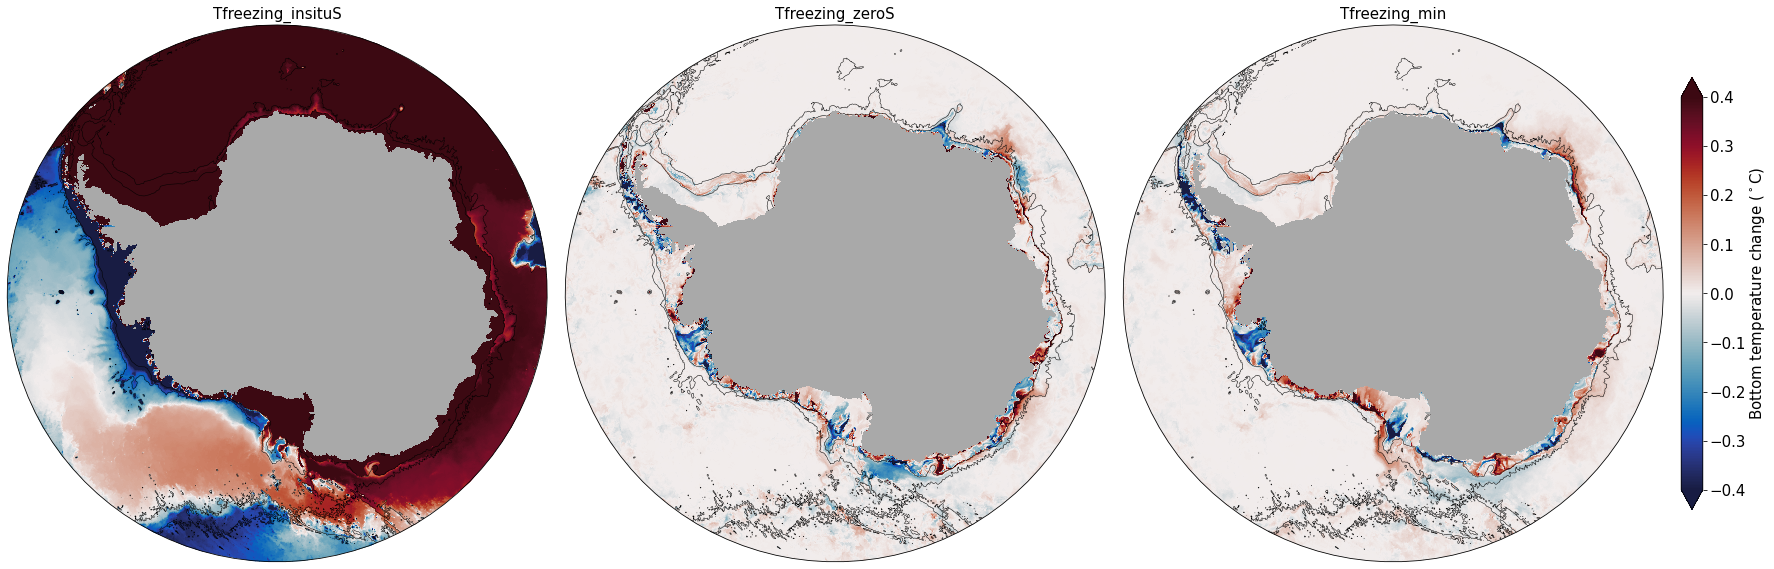

In [12]:
scale_max = .4

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_insituS-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_insituS',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_zeroS
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_zeroS-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_zeroS',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_min-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

## Timeseries of depth integrated salinity on shelf:
Why are the 3 formulations all nearly identical?

In [13]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
shelf_mask = shelf_mask.sel(yt_ocean=lat_slice)

In [23]:
# thickness area for depth averaging (not time varying):

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_con.yt_ocean,'xt_ocean':temp_con.xt_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

In [25]:
# area for area averaging:

area_t = cc.querying.getvar(control,'area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice)
area_t = area_t * shelf_mask

#area_sum = area_t.sum('xt_ocean').sum('yt_ocean')


In [30]:
volume = area_t*thickness
volume_sum = volume.sum()

In [33]:

start_time='2150-01-01'
end_time='2154-12-31'

salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
salt_con = salt_con*shelf_mask
# area and depth averaging on the shelf:
salt_con = (salt_con*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
salt_con = salt_con.load()                         

salt_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_insituS = salt_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
salt_Tfreezing_insituS = salt_Tfreezing_insituS*shelf_mask
# area and depth averaging on the shelf:
salt_Tfreezing_insituS = (salt_Tfreezing_insituS*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
salt_Tfreezing_insituS = salt_Tfreezing_insituS.load()                         

salt_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_zeroS = salt_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
salt_Tfreezing_zeroS = salt_Tfreezing_zeroS*shelf_mask
# area and depth averaging on the shelf:
salt_Tfreezing_zeroS = (salt_Tfreezing_zeroS*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
salt_Tfreezing_zeroS = salt_Tfreezing_zeroS.load()                         

salt_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_min = salt_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
salt_Tfreezing_min = salt_Tfreezing_min*shelf_mask
# area and depth averaging on the shelf:
salt_Tfreezing_min = (salt_Tfreezing_min*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
salt_Tfreezing_min = salt_Tfreezing_min.load()                         


Text(0.5, 1.0, 'Depth average salinity on the shelf')

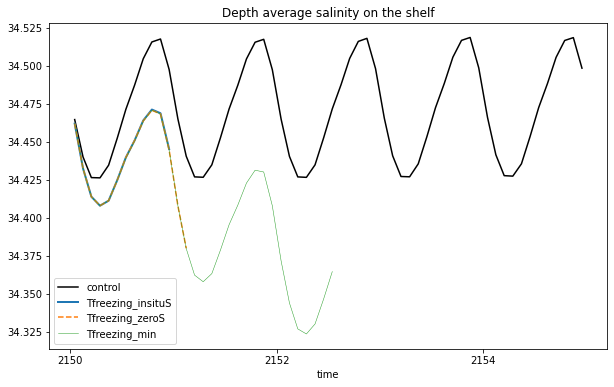

In [50]:
plt.figure(figsize=(10,6))

salt_con.plot(label='control',color='k')
salt_Tfreezing_insituS.plot(label='Tfreezing_insituS',linewidth=2)
salt_Tfreezing_zeroS.plot(label='Tfreezing_zeroS',linestyle='--')
salt_Tfreezing_min.plot(label='Tfreezing_min',linewidth=0.5)
plt.legend()
plt.title('Depth average salinity on the shelf')

In [ ]:
salt_Tfreezing_insituS

<xarray.DataArray (time: 12)>
array([34.46181492, 34.43234534, 34.41375599, 34.40782532, 34.41113112,
       34.4246453 , 34.43956799, 34.45079292, 34.46389318, 34.47107002,
       34.46864654, 34.44506993])
Coordinates:
  * time     (time) object 2150-01-16 12:00:00 ... 2150-12-16 12:00:00

In [41]:
salt_Tfreezing_zeroS

<xarray.DataArray (time: 14)>
array([34.46181636, 34.43234839, 34.41375337, 34.40784927, 34.4111474 ,
       34.42460291, 34.4395209 , 34.45074546, 34.46360587, 34.47060704,
       34.46817836, 34.44452565, 34.40772618, 34.37982619])
Coordinates:
  * time     (time) object 2150-01-16 12:00:00 ... 2151-02-15 00:00:00

In [42]:
salt_Tfreezing_min

<xarray.DataArray (time: 31)>
array([34.46181676, 34.43235203, 34.41376309, 34.40784063, 34.4111925 ,
       34.42458661, 34.43927514, 34.45050652, 34.46352873, 34.47066696,
       34.46816328, 34.44453492, 34.40781163, 34.3796146 , 34.36216723,
       34.35781537, 34.36316868, 34.37862463, 34.3953261 , 34.4082637 ,
       34.42270173, 34.43117002, 34.43000297, 34.40774249, 34.37154286,
       34.34386007, 34.32679476, 34.32345972, 34.3300505 , 34.34652417,
       34.36449484])
Coordinates:
  * time     (time) object 2150-01-16 12:00:00 ... 2152-07-16 12:00:00